The NFL is a multi-billion dollar business. There are millions of fans around the world, possibily even yourself, that invest a significant amount of time and resources to follow and watch their favorite teams and players. The teams are always working to fufill their duty to the fans. With the money they receive, they work on providing fans with the best experience possible, whether that's through giving them a great experience at the game with stadium rennovations or through building a winning team that makes fans want to tune in more. Every year, teams get around 225 million dollars to spend on players, with the money being paid through contracts. It's pretty straightforward, teams spend money on players that they think will benefit the team, and all is good, right? Obviously the answer is no, and there is a lot of nuance and subtleties that go into how much to pay players. Time and time again teams either give way too much money to certain players which ends up hurting the team, and many times teams avoid signing a certain player who ends up being a bargain for another. Then there is the question of how do we weigh which positions are worth more money. Each position has vastly different roles on a team, and therefore some are paid better than others. This however, also depends on the scheme the team has as that can affect how much they value each position. Then there are many more factors such as age and past performance that have to be accounted for. Then after all of that, even if done perfectly to the book can still end up not working. A player could not be a hard worker or lazy or had a fluke year, all of which are very hard to account for. So which are the factors you can account for? This is the question we will answer today, by looking through both basic box score predictions as well as ProFootballFocus' grading system, which breaks down the tape for every play of every player. This brings an element of context to the stats, which also can be deceiving based on what happens in a play, for example a quarterback can throw a perfect pass that gets dropped which would be considered an incompletion. We will do analysis on all different types of stats, advanced and basic, to determine which ones correlate with salary the best or how much each one correlates. This will give us a better picture of how we can predict what teams should pay a player based on their past performance and how much value in general they should add to a team. We will break down each category individually, by passing, rushing, receiving, blocking, run defense, pass rush and coverage, which will give us a nice split of positions and will allow us to differentiate the value of certain skills.

In [826]:
import pandas as pd
import numpy as np
import warnings

# filter out warnings
warnings.filterwarnings('ignore')

# get salary data 
tables = pd.read_html('https://www.spotrac.com/nfl/contracts/sort-value/limit-2000/')

First we must collect data, to do this we used the python library Pandas to read the html. Since the website we are collecting from stores the data we're looking for in a table tag we can easily grab it and store it in a dataframe. This website contains information for players salary including when they signed, total value, average annual value (AAV), and information relating to guaranteed salary.

In [827]:
import re

salary_df = tables[0].rename(columns={'Player': 'player'})
players = salary_df['player']
pl = []
start_years = []
end_years = []

for player in players:
    try:
        # split up player column and extract start year end year and name
        groups = re.search(r'(.*)  .* \| (\d{4})-(\d{4}) \(FA: (\d{4})\)', player)
        pl.append(groups.groups()[0])
        start_years.append(groups.groups()[1])
        end_years.append(groups.groups()[2])
    # if regex fails dont throw error
    except:
        pl.append(None)
        start_years.append(None)
        end_years.append(None)

# insert clean data
salary_df['player'] = pl
salary_df['start_year'] = start_years
salary_df['end_year'] = end_years

# turn salaries totals into ints
def convert_to_int(v):
    try: return int(v.replace('$', '').replace(',',''))
    except: return 0


salary_df['Value'] = salary_df['Value'].apply(convert_to_int)
salary_df['AAV'] = salary_df['AAV'].apply(convert_to_int)
salary_df['Sign Bonus'] = salary_df['Sign Bonus'].apply(convert_to_int)
salary_df["G'teed @ Sign"] = salary_df["G'teed @ Sign"].apply(convert_to_int)
salary_df["Practical G'teed"] = salary_df["Practical G'teed"].apply(convert_to_int)
salary_df['start_year'] = salary_df['start_year'].apply(convert_to_int)
salary_df['end_year'] = salary_df['end_year'].apply(convert_to_int)
salary_df.fillna(0)
salary_df

,Rank,player,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,1,Patrick Mahomes,24,10,450000000,45000000,10000000,63081905,141481905,2020,2031
1,2,Lamar Jackson,26,5,260000000,52000000,72500000,135000000,185000000,2023,2027
2,3,Josh Allen,25,6,258034000,43005667,16500000,100038596,150000000,2021,2028
3,4,Jalen Hurts,24,5,255000000,51000000,23294000,110000000,179399000,2023,2028
4,5,Russell Wilson,33,5,242588236,48517647,50000000,124000000,161000000,2022,2028
...,...,...,...,...,...,...,...,...,...,...,...
1995,1991,Mike Remmers,32,1,1120000,1120000,0,0,0,2022,2022
1996,1991,Maxx Williams,27,1,1120000,1120000,0,0,0,2022,2022
1997,1991,Mario Edwards,27,1,1120000,1120000,0,0,0,2022,2022
1998,1991,Bruce Irvin,34,1,1120000,1120000,0,0,0,2022,2022


Now we need to get the player stats. Do do this we extracted csv files from pff.com which contain many useful statistics for each position. Again we are going to store this in a pandas dataframe to be consistent, since we will use all the datasets together. We also need to clean the data. We do this by melting the data and removing any years in which very minimal snaps were played and to only include positions we want. We want to differentiate the years because of how important it is to account for. A player having a good season 5 years ago is not nearly the same as them playing well in the last season.

In [828]:
# passing players and stats

passing_dfs = []

# passing

# 2022
passing_dfs.append(pd.read_csv('./passing/passing_summary.csv'))
passing_dfs[0]['year'] = 2022

# 2021
passing_dfs.append(pd.read_csv('./passing/passing_summary (1).csv'))
passing_dfs[1]['year'] = 2021

# 2020
passing_dfs.append(pd.read_csv('./passing/passing_summary (2).csv'))
passing_dfs[2]['year'] = 2020

# 2019
passing_dfs.append(pd.read_csv('./passing/passing_summary (3).csv'))
passing_dfs[3]['year'] = 2019

# 2018
passing_dfs.append(pd.read_csv('./passing/passing_summary (4).csv'))
passing_dfs[4]['year'] = 2018


# 2017
passing_dfs.append(pd.read_csv('./passing/passing_summary (5).csv'))
passing_dfs[5]['year'] = 2017

# create dataframe
passing_df = pd.concat(passing_dfs)

# remove outliers
passing_df = passing_df[passing_df['position'] == 'QB']
passing_df = passing_df[passing_df['attempts'] > 100]

# merge players with salary
passing_df = pd.merge(passing_df, salary_df, on='player')
passing_df

,player,player_id,position,team_name,player_game_count,accuracy_percent,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Patrick Mahomes,11765,QB,KC,20,78.0,685,747,7.5,2.85,...,1,24,10,450000000,45000000,10000000,63081905,141481905,2020,2031
1,Patrick Mahomes,11765,QB,KC,20,79.2,708,780,7.4,2.87,...,1,24,10,450000000,45000000,10000000,63081905,141481905,2020,2031
2,Patrick Mahomes,11765,QB,KC,18,77.1,656,705,8.5,2.91,...,1,24,10,450000000,45000000,10000000,63081905,141481905,2020,2031
3,Patrick Mahomes,11765,QB,KC,17,77.2,549,596,8.5,2.84,...,1,24,10,450000000,45000000,10000000,63081905,141481905,2020,2031
4,Patrick Mahomes,11765,QB,KC,18,77.8,595,652,9.6,2.80,...,1,24,10,450000000,45000000,10000000,63081905,141481905,2020,2031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,Case Keenum,7323,QB,MIN,17,75.1,527,569,7.9,2.72,...,630,35,2,6250000,3125000,750000,4000000,4000000,2023,2024
182,David Blough,46508,QB,DET,5,68.6,159,174,8.9,2.89,...,1875,27,1,1232500,1232500,76250,76250,76250,2023,2023
183,Blaine Gabbert,6162,QB,TEN,6,66.3,98,101,7.7,2.29,...,1810,33,1,1317500,1317500,152500,1092500,1092500,2023,2023
184,Blaine Gabbert,6162,QB,ARZ,5,65.8,161,171,9.8,2.58,...,1810,33,1,1317500,1317500,152500,1092500,1092500,2023,2023


In [829]:
# rushing players and stats

rushing_dfs = []

# rushing

# 2022
rushing_dfs.append(pd.read_csv('./rushing/rushing_summary.csv'))
rushing_dfs[0]['year'] = 2022

# 2021
rushing_dfs.append(pd.read_csv('./rushing/rushing_summary (1).csv'))
rushing_dfs[1]['year'] = 2021

# 2020
rushing_dfs.append(pd.read_csv('./rushing/rushing_summary (2).csv'))
rushing_dfs[2]['year'] = 2020

# 2019
rushing_dfs.append(pd.read_csv('./rushing/rushing_summary (3).csv'))
rushing_dfs[3]['year'] = 2019

# 2018
rushing_dfs.append(pd.read_csv('./rushing/rushing_summary (4).csv'))
rushing_dfs[4]['year'] = 2018


# 2017
rushing_dfs.append(pd.read_csv('./rushing/rushing_summary (5).csv'))
rushing_dfs[5]['year'] = 2017

# create dataframe
rushing_df = pd.concat(rushing_dfs)

# remove outliers
rushing_df = rushing_df[rushing_df['position'] == 'HB']
rushing_df = rushing_df[rushing_df['attempts'] > 50]

# merge players with salary
rushing_df = pd.merge(rushing_df, salary_df, on='player')
rushing_df

,player,player_id,position,team_name,player_game_count,attempts,avoided_tackles,breakaway_attempts,breakaway_percent,breakaway_yards,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Derrick Henry,10679,HB,TEN,16,349,69,15,27.6,424,...,142,26,4,50000000,12500000,12000000,25500000,25500000,2020,2023
1,Derrick Henry,10679,HB,TEN,9,239,36,9,26.4,264,...,142,26,4,50000000,12500000,12000000,25500000,25500000,2020,2023
2,Derrick Henry,10679,HB,TEN,17,396,77,21,31.2,645,...,142,26,4,50000000,12500000,12000000,25500000,25500000,2020,2023
3,Derrick Henry,10679,HB,TEN,18,386,71,23,33.5,665,...,142,26,4,50000000,12500000,12000000,25500000,25500000,2020,2023
4,Derrick Henry,10679,HB,TEN,16,215,45,9,27.6,292,...,142,26,4,50000000,12500000,12000000,25500000,25500000,2020,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,Ameer Abdullah,9487,HB,DET,14,165,20,7,31.9,176,...,1728,29,1,1750000,1750000,200000,500000,500000,2023,2023
213,Benny Snell Jr.,45954,HB,PIT,16,113,14,3,21.0,80,...,1251,21,4,3222068,805517,702068,702068,702068,2019,2022
214,Benny Snell Jr.,45954,HB,PIT,11,108,20,5,23.0,98,...,1251,21,4,3222068,805517,702068,702068,702068,2019,2022
215,Justice Hill,45865,HB,BLT,17,58,8,1,8.0,18,...,825,25,2,4510000,2255000,1000000,1250000,1250000,2023,2024


In [830]:
# receiving players and stats

receiving_dfs = []

# receiving

# 2022
receiving_dfs.append(pd.read_csv('./receiving/receiving_summary.csv'))
receiving_dfs[0]['year'] = 2022

# 2021
receiving_dfs.append(pd.read_csv('./receiving/receiving_summary (1).csv'))
receiving_dfs[1]['year'] = 2021

# 2020
receiving_dfs.append(pd.read_csv('./receiving/receiving_summary (2).csv'))
receiving_dfs[2]['year'] = 2020

# 2019
receiving_dfs.append(pd.read_csv('./receiving/receiving_summary (3).csv'))
receiving_dfs[3]['year'] = 2019

# 2018
receiving_dfs.append(pd.read_csv('./receiving/receiving_summary (4).csv'))
receiving_dfs[4]['year'] = 2018


# 2017
receiving_dfs.append(pd.read_csv('./receiving/receiving_summary (5).csv'))
receiving_dfs[5]['year'] = 2017

# create dataframe
receiving_df = pd.concat(receiving_dfs)

# remove outliers
receiving_df = receiving_df[receiving_df['targets'] > 50]

# merge players with salary
receiving_df = pd.merge(receiving_df, salary_df, on='player')
receiving_df

,player,player_id,position,team_name,player_game_count,avg_depth_of_target,avoided_tackles,caught_percent,contested_catch_rate,contested_receptions,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Justin Jefferson,61398,WR,MIN,18,10.7,11,73.0,55.0,22,...,418,21,4,13122805,3280701,7103856,13122805,13122805,2020,2024
1,Justin Jefferson,61398,WR,MIN,17,13.3,9,66.3,48.1,13,...,418,21,4,13122805,3280701,7103856,13122805,13122805,2020,2024
2,Justin Jefferson,61398,WR,MIN,16,12.0,13,72.7,54.5,12,...,418,21,4,13122805,3280701,7103856,13122805,13122805,2020,2024
3,Travis Kelce,7844,TE,KC,20,7.5,25,75.3,45.5,10,...,115,30,4,57250000,14312500,0,20750000,22750000,2020,2025
4,Travis Kelce,7844,TE,KC,19,7.6,23,72.8,60.0,9,...,115,30,4,57250000,14312500,0,20750000,22750000,2020,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Antonio Callaway,48101,WR,CLV,16,14.5,3,55.1,38.5,5,...,1662,25,2,2135000,1067500,0,0,0,2023,2024
496,David Johnson,9519,HB,ARZ,16,0.6,10,71.4,40.0,2,...,1991,30,1,1120000,1120000,0,0,0,2022,2022
497,Marquise Goodwin,7859,WR,SF,16,16.0,6,56.6,50.0,11,...,1735,32,1,1700000,1700000,250000,400000,400000,2023,2023
498,Trent Taylor,11932,WR,SF,15,6.9,4,72.9,66.7,8,...,1875,28,1,1232500,1232500,52500,52500,52500,2023,2023


In [831]:
# get wide receiver data
wr_df = receiving_df[receiving_df['position'] == 'WR']
wr_df

,player,player_id,position,team_name,player_game_count,avg_depth_of_target,avoided_tackles,caught_percent,contested_catch_rate,contested_receptions,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Justin Jefferson,61398,WR,MIN,18,10.7,11,73.0,55.0,22,...,418,21,4,13122805,3280701,7103856,13122805,13122805,2020,2024
1,Justin Jefferson,61398,WR,MIN,17,13.3,9,66.3,48.1,13,...,418,21,4,13122805,3280701,7103856,13122805,13122805,2020,2024
2,Justin Jefferson,61398,WR,MIN,16,12.0,13,72.7,54.5,12,...,418,21,4,13122805,3280701,7103856,13122805,13122805,2020,2024
9,Tyreek Hill,10799,WR,MIA,18,12.6,12,69.6,50.0,13,...,19,28,4,120000000,30000000,25500000,52535000,72200000,2022,2026
10,Tyreek Hill,10799,WR,KC,20,10.6,15,73.6,28.6,6,...,19,28,4,120000000,30000000,25500000,52535000,72200000,2022,2026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,Randall Cobb,6216,WR,GB,15,6.1,5,77.6,38.5,5,...,1257,32,1,3000000,3000000,250000,250000,250000,2023,2023
489,Phillip Dorsett,9462,WR,NE,15,15.5,0,50.0,36.4,4,...,1934,30,1,1217500,1217500,0,0,0,2023,2023
495,Antonio Callaway,48101,WR,CLV,16,14.5,3,55.1,38.5,5,...,1662,25,2,2135000,1067500,0,0,0,2023,2024
497,Marquise Goodwin,7859,WR,SF,16,16.0,6,56.6,50.0,11,...,1735,32,1,1700000,1700000,250000,400000,400000,2023,2023


In [832]:
# tight end data
te_df = receiving_df[receiving_df['position'] == 'TE']
te_df

,player,player_id,position,team_name,player_game_count,avg_depth_of_target,avoided_tackles,caught_percent,contested_catch_rate,contested_receptions,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
3,Travis Kelce,7844,TE,KC,20,7.5,25,75.3,45.5,10,...,115,30,4,57250000,14312500,0,20750000,22750000,2020,2025
4,Travis Kelce,7844,TE,KC,19,7.6,23,72.8,60.0,9,...,115,30,4,57250000,14312500,0,20750000,22750000,2020,2025
5,Travis Kelce,7844,TE,KC,18,8.9,16,76.4,30.4,7,...,115,30,4,57250000,14312500,0,20750000,22750000,2020,2025
6,Travis Kelce,7844,TE,KC,19,9.1,18,76.3,53.8,14,...,115,30,4,57250000,14312500,0,20750000,22750000,2020,2025
7,Travis Kelce,7844,TE,KC,18,9.3,11,73.4,64.0,16,...,115,30,4,57250000,14312500,0,20750000,22750000,2020,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,Kyle Rudolph,6195,TE,MIN,16,7.3,4,84.2,53.8,7,...,1674,32,1,2000000,2000000,500000,2000000,2000000,2022,2022
492,Kyle Rudolph,6195,TE,MIN,18,8.2,3,72.4,38.9,7,...,1674,32,1,2000000,2000000,500000,2000000,2000000,2022,2022
493,Jordan Akins,47050,TE,HST,16,7.4,8,67.9,25.0,2,...,1049,30,2,3900000,1950000,630000,1730000,1730000,2023,2024
494,O.J. Howard,11774,TE,TB,14,10.1,2,65.4,41.7,5,...,1875,28,1,1232500,1232500,76250,451250,451250,2023,2023


In [833]:
# offense_blocking players and stats

offense_blocking_dfs = []

# offense_blocking

# 2022
offense_blocking_dfs.append(pd.read_csv('./offense_blocking/offense_blocking.csv'))
offense_blocking_dfs[0]['year'] = 2022

# 2021
offense_blocking_dfs.append(pd.read_csv('./offense_blocking/offense_blocking (1).csv'))
offense_blocking_dfs[1]['year'] = 2021

# 2020
offense_blocking_dfs.append(pd.read_csv('./offense_blocking/offense_blocking (2).csv'))
offense_blocking_dfs[2]['year'] = 2020

# 2019
offense_blocking_dfs.append(pd.read_csv('./offense_blocking/offense_blocking (3).csv'))
offense_blocking_dfs[3]['year'] = 2019

# 2018
offense_blocking_dfs.append(pd.read_csv('./offense_blocking/offense_blocking (4).csv'))
offense_blocking_dfs[4]['year'] = 2018


# 2017
offense_blocking_dfs.append(pd.read_csv('./offense_blocking/offense_blocking (5).csv'))
offense_blocking_dfs[5]['year'] = 2017

# create dataframe
offense_blocking_df = pd.concat(offense_blocking_dfs)

# remove outliers
offense_blocking_df = offense_blocking_df[offense_blocking_df['snap_counts_block'] > 100]

# merge players with salary
offense_blocking_df = pd.merge(offense_blocking_df, salary_df, on='player')
offense_blocking_df

,player,player_id,position,team_name,player_game_count,block_percent,declined_penalties,franchise_id,grades_offense,grades_pass_block,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Jason Kelce,6343,C,PHI,20,100.0,1,24,89.4,83.3,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
1,Jason Kelce,6343,C,PHI,18,100.0,0,24,84.5,69.2,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
2,Jason Kelce,6343,C,PHI,16,100.0,0,24,69.6,62.0,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
3,Jason Kelce,6343,C,PHI,17,100.0,1,24,81.1,67.6,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
4,Jason Kelce,6343,C,PHI,18,100.0,0,24,87.1,88.0,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,Brian Hoyer,5277,QB,NE,12,34.5,0,19,63.6,NaN,...,826,37,2,4500000,2250000,875000,4205000,4205000,2023,2024
1796,Cordarrelle Patterson,7810,WR,OAK,16,29.6,0,23,65.5,62.4,...,481,31,2,10500000,5250000,5000000,5000000,5000000,2022,2023
1797,Blaine Gabbert,6162,QB,ARZ,5,33.3,0,1,45.4,NaN,...,1810,33,1,1317500,1317500,152500,1092500,1092500,2023,2023
1798,Trent Taylor,11932,WR,SF,15,22.5,0,28,68.4,69.6,...,1875,28,1,1232500,1232500,52500,52500,52500,2023,2023


In [834]:
# center data
c_df = offense_blocking_df[offense_blocking_df['position'] == 'C']
c_df

,player,player_id,position,team_name,player_game_count,block_percent,declined_penalties,franchise_id,grades_offense,grades_pass_block,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Jason Kelce,6343,C,PHI,20,100.0,1,24,89.4,83.3,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
1,Jason Kelce,6343,C,PHI,18,100.0,0,24,84.5,69.2,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
2,Jason Kelce,6343,C,PHI,16,100.0,0,24,69.6,62.0,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
3,Jason Kelce,6343,C,PHI,17,100.0,1,24,81.1,67.6,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
4,Jason Kelce,6343,C,PHI,18,100.0,0,24,87.1,88.0,...,386,35,1,14250000,14250000,10335000,14250000,14250000,2023,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,Michael Deiter,38554,C,MIA,8,100.0,1,17,60.6,57.2,...,1875,26,1,1232500,1232500,125000,125000,125000,2023,2023
1607,Kyle Fuller,11998,C,SEA,10,100.0,0,29,46.5,31.3,...,1624,30,1,2500000,2500000,1380000,2500000,2500000,2022,2022
1657,Trey Hill,81653,C,CIN,7,100.0,1,7,53.3,65.3,...,1156,21,4,3672352,918088,192352,192352,192352,2021,2024
1700,Trystan Colon-Castillo,41117,C,BLT,12,98.0,0,3,62.6,74.5,...,1765,24,1,1660000,1660000,250000,250000,250000,2023,2023


In [835]:
# guard data
g_df = offense_blocking_df[offense_blocking_df['position'] == 'G']
g_df

,player,player_id,position,team_name,player_game_count,block_percent,declined_penalties,franchise_id,grades_offense,grades_pass_block,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
6,Isaac Seumalo,10713,G,PHI,20,100.0,3,24,72.7,78.2,...,256,29,3,24000000,8000000,6950000,6950000,6950000,2023,2025
7,Isaac Seumalo,10713,G,PHI,3,100.0,0,24,74.8,82.9,...,256,29,3,24000000,8000000,6950000,6950000,6950000,2023,2025
8,Isaac Seumalo,10713,G,PHI,9,100.0,0,24,62.4,77.4,...,256,29,3,24000000,8000000,6950000,6950000,6950000,2023,2025
9,Isaac Seumalo,10713,G,PHI,17,100.0,0,24,70.6,70.1,...,256,29,3,24000000,8000000,6950000,6950000,6950000,2023,2025
10,Isaac Seumalo,10713,G,PHI,15,99.8,1,24,67.3,64.4,...,256,29,3,24000000,8000000,6950000,6950000,6950000,2023,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,Shane Lemieux,28149,G,NYG,11,100.0,2,21,32.2,16.9,...,1170,23,4,3642140,910535,347140,347140,347140,2020,2023
1733,Colton McKivitz,29314,G,SF,9,100.0,0,28,53.1,49.9,...,812,26,2,4610000,2305000,730000,1870000,1870000,2023,2024
1734,Chris Hubbard,8051,G,CLV,8,100.0,0,8,71.9,78.3,...,1323,30,1,2622500,2622500,152500,2622500,2622500,2022,2022
1743,Aaron Stinnie,28653,G,TB,6,100.0,0,30,57.6,41.9,...,1799,28,1,1400000,1400000,0,150000,150000,2023,2023


In [836]:
# tackle data
t_df = offense_blocking_df[offense_blocking_df['position'] == 'T']
t_df

,player,player_id,position,team_name,player_game_count,block_percent,declined_penalties,franchise_id,grades_offense,grades_pass_block,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
14,Orlando Brown Jr.,46227,T,KC,20,100.0,1,16,75.4,76.8,...,93,26,4,64092000,16023000,31100000,31100000,31100000,2023,2026
15,Orlando Brown Jr.,46227,T,KC,19,100.0,3,16,75.4,74.4,...,93,26,4,64092000,16023000,31100000,31100000,31100000,2023,2026
16,Orlando Brown Jr.,46227,T,BLT,18,100.0,0,3,77.8,77.8,...,93,26,4,64092000,16023000,31100000,31100000,31100000,2023,2026
17,Orlando Brown Jr.,46227,T,BLT,17,100.0,2,3,73.6,83.3,...,93,26,4,64092000,16023000,31100000,31100000,31100000,2023,2026
18,Orlando Brown Jr.,46227,T,BLT,16,100.0,0,3,68.6,75.1,...,93,26,4,64092000,16023000,31100000,31100000,31100000,2023,2026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,Kendall Lamm,10017,T,CLV,10,98.4,1,8,66.7,69.5,...,1810,30,1,1317500,1317500,100000,200000,200000,2023,2023
1750,Kendall Lamm,10017,T,HST,15,100.0,0,13,65.2,76.0,...,1810,30,1,1317500,1317500,100000,200000,200000,2023,2023
1751,Kendall Lamm,10017,T,HST,6,100.0,0,13,58.4,50.2,...,1810,30,1,1317500,1317500,100000,200000,200000,2023,2023
1786,Ja'Wuan James,8654,T,MIA,15,99.9,4,17,72.4,67.4,...,821,29,2,4575000,2287500,500000,500000,500000,2021,2022


In [837]:
# run_defense players and stats

run_defense_dfs = []

# run_defense

# 2022
run_defense_dfs.append(pd.read_csv('./run_defense/run_defense_summary.csv'))
run_defense_dfs[0]['year'] = 2022

# 2021
run_defense_dfs.append(pd.read_csv('./run_defense/run_defense_summary (1).csv'))
run_defense_dfs[1]['year'] = 2021

# 2020
run_defense_dfs.append(pd.read_csv('./run_defense/run_defense_summary (2).csv'))
run_defense_dfs[2]['year'] = 2020

# 2019
run_defense_dfs.append(pd.read_csv('./run_defense/run_defense_summary (3).csv'))
run_defense_dfs[3]['year'] = 2019

# 2018
run_defense_dfs.append(pd.read_csv('./run_defense/run_defense_summary (4).csv'))
run_defense_dfs[4]['year'] = 2018


# 2017
run_defense_dfs.append(pd.read_csv('./run_defense/run_defense_summary (5).csv'))
run_defense_dfs[5]['year'] = 2017

# create dataframe
run_defense_df = pd.concat(run_defense_dfs)

# remove outliers
run_defense_df = run_defense_df[run_defense_df['snap_counts_run'] > 100]

# merge players with salary
run_defense_df = pd.merge(run_defense_df, salary_df, on='player')
run_defense_df

,player,player_id,position,team_name,player_game_count,assists,avg_depth_of_tackle,declined_penalties,forced_fumbles,franchise_id,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Calais Campbell,4364,DI,BLT,15,11,3.5,1,0,3,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
1,Calais Campbell,4364,DI,BLT,15,12,2.1,1,0,3,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
2,Calais Campbell,4364,DI,BLT,14,5,1.5,0,0,3,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
3,Calais Campbell,4364,DI,JAX,16,10,1.5,0,2,15,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
4,Calais Campbell,4364,ED,JAX,16,10,0.8,0,1,15,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,Jason Cabinda,50714,LB,OAK,10,3,5.6,0,0,23,...,938,25,2,4100000,2050000,1000000,2035000,2035000,2022,2023
1861,Leonard Johnson,7385,CB,BUF,16,1,3.8,1,0,4,...,1312,24,3,2695000,898333,0,0,0,2023,2025
1862,Justin Bethel,7654,CB,ARZ,9,4,5.2,0,0,1,...,1810,32,1,1317500,1317500,75000,75000,75000,2023,2023
1863,Cody Davis,8458,S,LA,7,4,8.6,0,0,26,...,1661,33,1,2200000,2200000,0,500000,500000,2023,2023


In [838]:
# pass_rush players and stats

pass_rush_dfs = []

# pass_rush

# 2022
pass_rush_dfs.append(pd.read_csv('./pass_rush/pass_rush_summary.csv'))
pass_rush_dfs[0]['year'] = 2022

# 2021
pass_rush_dfs.append(pd.read_csv('./pass_rush/pass_rush_summary (1).csv'))
pass_rush_dfs[1]['year'] = 2021

# 2020
pass_rush_dfs.append(pd.read_csv('./pass_rush/pass_rush_summary (2).csv'))
pass_rush_dfs[2]['year'] = 2020

# 2019
pass_rush_dfs.append(pd.read_csv('./pass_rush/pass_rush_summary (3).csv'))
pass_rush_dfs[3]['year'] = 2019

# 2018
pass_rush_dfs.append(pd.read_csv('./pass_rush/pass_rush_summary (4).csv'))
pass_rush_dfs[4]['year'] = 2018


# 2017
pass_rush_dfs.append(pd.read_csv('./pass_rush/pass_rush_summary (5).csv'))
pass_rush_dfs[5]['year'] = 2017

# create dataframe
pass_rush_df = pd.concat(pass_rush_dfs)

# remove outliers
pass_rush_df = pass_rush_df[pass_rush_df['snap_counts_pass_rush'] > 100]

# merge players with salary
pass_rush_df = pd.merge(pass_rush_df, salary_df, on='player')
pass_rush_df

,player,player_id,position,team_name,player_game_count,batted_passes,declined_penalties,franchise_id,grades_pass_rush_defense,hits,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Calais Campbell,4364,DI,BLT,15,2,1,3,71.7,12,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
1,Calais Campbell,4364,DI,BLT,15,1,1,3,69.5,11,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
2,Calais Campbell,4364,DI,BLT,14,6,0,3,73.0,4,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
3,Calais Campbell,4364,DI,JAX,16,1,0,15,81.4,19,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
4,Calais Campbell,4364,ED,JAX,16,2,0,15,70.4,11,...,598,36,1,7000000,7000000,3000000,7000000,7000000,2023,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,C.J. Mosley,8652,LB,BLT,16,1,0,3,57.3,1,...,47,26,5,85000000,17000000,7500000,43000000,51000000,2019,2024
969,Jarrad Davis,11776,LB,DET,16,0,0,11,74.5,3,...,1960,28,1,1180000,1180000,0,0,0,2023,2023
970,Jayon Brown,11910,LB,TEN,16,0,0,31,86.6,4,...,1870,27,1,1250000,1250000,125000,625000,625000,2022,2022
971,Deadrin Senat,48815,DI,ATL,15,0,0,2,68.7,2,...,1875,28,1,1232500,1232500,152500,652500,652500,2023,2023


In [839]:
# defense_coverage players and stats

defense_coverage_dfs = []

# defense_coverage

# 2022
defense_coverage_dfs.append(pd.read_csv('./defense_coverage/defense_coverage_summary.csv'))
defense_coverage_dfs[0]['year'] = 2022

# 2021
defense_coverage_dfs.append(pd.read_csv('./defense_coverage/defense_coverage_summary (1).csv'))
defense_coverage_dfs[1]['year'] = 2021

# 2020
defense_coverage_dfs.append(pd.read_csv('./defense_coverage/defense_coverage_summary (2).csv'))
defense_coverage_dfs[2]['year'] = 2020

# 2019
defense_coverage_dfs.append(pd.read_csv('./defense_coverage/defense_coverage_summary (3).csv'))
defense_coverage_dfs[3]['year'] = 2019

# 2018
defense_coverage_dfs.append(pd.read_csv('./defense_coverage/defense_coverage_summary (4).csv'))
defense_coverage_dfs[4]['year'] = 2018


# 2017
defense_coverage_dfs.append(pd.read_csv('./defense_coverage/defense_coverage_summary (5).csv'))
defense_coverage_dfs[5]['year'] = 2017

# create dataframe
defense_coverage_df = pd.concat(defense_coverage_dfs)

# remove outliers
defense_coverage_df = defense_coverage_df[defense_coverage_df['snap_counts_coverage'] > 100]

# merge players with salary
defense_coverage_df = pd.merge(defense_coverage_df, salary_df, on='player')
defense_coverage_df

,player,player_id,position,team_name,player_game_count,assists,avg_depth_of_target,catch_rate,coverage_percent,coverage_snaps_per_reception,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Patrick Peterson,6157,CB,MIN,18,2,12.1,60.0,99.3,14.6,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
1,Patrick Peterson,6157,CB,MIN,13,3,10.0,57.8,100.0,13.9,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
2,Patrick Peterson,6157,CB,ARZ,16,2,12.1,66.7,99.4,12.8,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
3,Patrick Peterson,6157,CB,ARZ,10,3,10.4,67.2,99.3,10.8,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
4,Patrick Peterson,6157,CB,ARZ,16,2,11.7,57.7,99.5,19.2,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,Bruce Irvin,7021,ED,OAK,16,2,1.2,81.8,23.5,6.7,...,1991,34,1,1120000,1120000,0,0,0,2022,2022
1131,Leonard Johnson,7385,CB,BUF,16,2,6.3,71.1,96.6,7.2,...,1312,24,3,2695000,898333,0,0,0,2023,2025
1132,Cody Davis,8458,S,LA,7,0,12.4,22.2,98.3,82.0,...,1661,33,1,2200000,2200000,0,500000,500000,2023,2023
1133,Bud Dupree,9455,ED,PIT,16,0,6.9,69.2,27.1,14.4,...,1257,30,1,3000000,3000000,1250000,2490000,2490000,2023,2023


In [840]:
idl_df = pd.merge(run_defense_df[run_defense_df['position'] == 'DI'], pass_rush_df[pass_rush_df['position'] == 'DI'])
idl_df

,player,player_id,position,team_name,player_game_count,assists,avg_depth_of_tackle,declined_penalties,forced_fumbles,franchise_id,...,true_pass_set_hurries,true_pass_set_pass_rush_opp,true_pass_set_pass_rush_percent,true_pass_set_pass_rush_win_rate,true_pass_set_pass_rush_wins,true_pass_set_prp,true_pass_set_sacks,true_pass_set_snap_counts_pass_play,true_pass_set_snap_counts_pass_rush,true_pass_set_total_pressures
0,Calais Campbell,4364,DI,BLT,15,11,3.5,1,0,3,...,13,183,98.5,21.3,39,9.0,6,196,193,27
1,Calais Campbell,4364,DI,BLT,15,12,2.1,1,0,3,...,15,183,100.0,15.3,28,5.7,0,194,194,21
2,Calais Campbell,4364,DI,BLT,14,5,1.5,0,0,3,...,12,131,98.0,13.7,18,6.5,2,151,148,15
3,Calais Campbell,4364,DI,JAX,16,10,1.5,0,2,15,...,28,218,100.0,22.9,50,11.2,5,238,238,44
4,Tyson Alualu,5535,DI,PIT,17,2,2.6,0,0,25,...,6,72,100.0,9.7,7,5.6,0,75,75,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,L.J. Collier,48822,DI,SEA,17,5,1.4,0,0,29,...,6,97,99.0,14.4,14,6.7,3,101,100,10
433,Daniel Ekuale,48874,DI,JAX,9,7,3.0,0,0,15,...,0,29,100.0,3.4,1,1.7,0,32,32,1
434,Sheldon Day,10737,DI,SF,19,3,1.9,0,0,28,...,2,48,100.0,6.3,3,4.2,1,50,50,3
435,Sheldon Day,10737,DI,SF,12,2,3.5,0,0,28,...,8,60,100.0,18.3,11,10.0,2,61,61,10


In [841]:
edge_df = pd.merge(run_defense_df[run_defense_df['position'] == 'ED'], pass_rush_df[pass_rush_df['position'] == 'ED'])
edge_df

,player,player_id,position,team_name,player_game_count,assists,avg_depth_of_tackle,declined_penalties,forced_fumbles,franchise_id,...,true_pass_set_hurries,true_pass_set_pass_rush_opp,true_pass_set_pass_rush_percent,true_pass_set_pass_rush_win_rate,true_pass_set_pass_rush_wins,true_pass_set_prp,true_pass_set_sacks,true_pass_set_snap_counts_pass_play,true_pass_set_snap_counts_pass_rush,true_pass_set_total_pressures
0,Calais Campbell,4364,ED,JAX,16,10,0.8,0,1,15,...,18,204,100.0,17.6,36,10.8,11,223,223,33
1,Calais Campbell,4364,ED,JAX,19,13,1.9,0,1,15,...,35,321,100.0,24.9,80,12.3,15,344,344,64
2,Brandon Graham,5538,ED,PHI,20,2,1.1,0,0,24,...,21,144,96.8,31.3,45,16.0,12,158,153,34
3,Brandon Graham,5538,ED,PHI,16,6,1.7,0,0,24,...,20,140,96.8,27.1,38,12.5,5,156,151,30
4,Brandon Graham,5538,ED,PHI,17,6,0.5,0,1,24,...,26,235,97.3,20.4,48,10.4,8,258,251,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Isaac Rochell,11980,ED,LAC,18,2,2.4,0,0,27,...,16,193,100.0,14.0,27,7.5,6,210,210,23
358,Takkarist McKinley,11781,ED,ATL,14,6,2.9,0,0,2,...,12,99,91.7,20.2,20,10.6,2,120,110,19
359,Takkarist McKinley,11781,ED,ATL,15,3,3.2,0,0,2,...,24,193,99.1,20.7,40,11.1,6,217,215,37
360,Takkarist McKinley,11781,ED,ATL,18,4,0.4,1,0,2,...,23,148,99.4,23.0,34,13.5,7,159,158,33


In [842]:
lb_df = pd.merge(run_defense_df[run_defense_df['position'] == 'LB'], defense_coverage_df[defense_coverage_df['position'] == 'LB'])
lb_df

,player,player_id,position,team_name,player_game_count,assists,avg_depth_of_tackle,declined_penalties,forced_fumbles,franchise_id,...,qb_rating_against,receptions,snap_counts_coverage,snap_counts_pass_play,targets,touchdowns,yards,yards_after_catch,yards_per_coverage_snap,yards_per_reception


In [843]:
# cornerbacks
cb_df = defense_coverage_df[defense_coverage_df['position'] == 'CB']
cb_df

,player,player_id,position,team_name,player_game_count,assists,avg_depth_of_target,catch_rate,coverage_percent,coverage_snaps_per_reception,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
0,Patrick Peterson,6157,CB,MIN,18,2,12.1,60.0,99.3,14.6,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
1,Patrick Peterson,6157,CB,MIN,13,3,10.0,57.8,100.0,13.9,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
2,Patrick Peterson,6157,CB,ARZ,16,2,12.1,66.7,99.4,12.8,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
3,Patrick Peterson,6157,CB,ARZ,10,3,10.4,67.2,99.3,10.8,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
4,Patrick Peterson,6157,CB,ARZ,16,2,11.7,57.7,99.5,19.2,...,394,32,2,14000000,7000000,5850000,5850000,5850000,2023,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,Lamar Jackson,50532,CB,NYJ,8,2,12.1,66.7,100.0,9.8,...,2,26,5,260000000,52000000,72500000,135000000,185000000,2023,2027
1120,Siran Neal,27130,CB,BUF,7,1,5.6,72.2,91.8,9.0,...,515,27,3,9000000,3000000,1600000,2900000,3300000,2022,2024
1122,Corey Ballentine,83833,CB,NYG,8,0,10.8,72.1,95.6,5.8,...,1982,26,1,1140000,1140000,60000,60000,60000,2023,2023
1129,Tony Brown,49255,CB,GB,10,1,10.9,63.2,100.0,7.0,...,1875,26,1,1232500,1232500,152500,500000,500000,2023,2023


In [844]:
# Safeties
s_df = defense_coverage_df[defense_coverage_df['position'] == 'S']
s_df

,player,player_id,position,team_name,player_game_count,assists,avg_depth_of_target,catch_rate,coverage_percent,coverage_snaps_per_reception,...,Rank,Signed Age,Yrs,Value,AAV,Sign Bonus,G'teed @ Sign,Practical G'teed,start_year,end_year
30,Harrison Smith,7641,S,MIN,15,5,10.0,80.0,97.8,16.4,...,96,32,4,64000000,16000000,9579410,14179410,26379410,2021,2025
31,Harrison Smith,7641,S,MIN,15,9,10.1,74.1,93.5,28.9,...,96,32,4,64000000,16000000,9579410,14179410,26379410,2021,2025
32,Harrison Smith,7641,S,MIN,16,10,15.6,65.4,93.9,31.3,...,96,32,4,64000000,16000000,9579410,14179410,26379410,2021,2025
33,Harrison Smith,7641,S,MIN,17,10,9.3,66.7,94.4,25.3,...,96,32,4,64000000,16000000,9579410,14179410,26379410,2021,2025
34,Harrison Smith,7641,S,MIN,16,1,12.4,66.7,92.7,22.2,...,96,32,4,64000000,16000000,9579410,14179410,26379410,2021,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,Michael Thomas,7279,S,NYG,16,4,6.8,82.6,90.6,9.7,...,1963,32,1,1165000,1165000,0,0,0,2023,2023
1116,Michael Thomas,7279,S,NYG,16,3,6.8,63.6,92.6,14.1,...,487,30,1,10000000,10000000,5000000,10000000,10000000,2023,2024
1117,Michael Thomas,7279,S,NYG,16,3,6.8,63.6,92.6,14.1,...,1963,32,1,1165000,1165000,0,0,0,2023,2023
1132,Cody Davis,8458,S,LA,7,0,12.4,22.2,98.3,82.0,...,1661,33,1,2200000,2200000,0,500000,500000,2023,2023


Now we need to explore our data and understand it. This is where we analyze the features of our dataset and start to determine which ones are more valueable for our hypothesis. To do this we will use single vector decomposition. We will import svds from the scipy linear algebra library and apply it to our data. We need to first remove any irrelevant data from ourdatasets such as player_id, franchise_id and team and handle any missing data. For missing data we replaced it with the mean from that column. Since pretty much all missing data has already been dropped this will not affect the analysis here much.

In [845]:
import numpy as np
from scipy.sparse.linalg import svds

# passing_df = passing_df.fillna(passing_df.mean())
numeric_cols = passing_df.select_dtypes(include=[np.number]).columns.tolist()

passing_df[numeric_cols] = passing_df[numeric_cols].replace(-1, passing_df[numeric_cols].mean()).fillna(passing_df[numeric_cols].mean())

# Extract the matrix of numerical features you want to perform SVD on
features = passing_df.select_dtypes(include=[np.number])

features = features.drop([ 'year',
       'Signed Age', 'Yrs', 'Value', 'AAV', 'Sign Bonus', "G'teed @ Sign",
       "Practical G'teed", 'player_id', 'franchise_id', 'Rank', 'start_year', 'end_year', 'attempts', 'passing_snaps'], axis=1)

cols = len(features.columns) -1
features
# Perform SVD on the matrix
U, S, Vt = svds(features.to_numpy(), k=cols)

# Check the shape of the SVD factors
Vt[cols-1]
features.shape
covariance = np.dot(features.to_numpy().T, features.to_numpy())
covariance.shape
U, S, Vt = svds(covariance, k=cols)
print('Shape of U:', U.shape)
print('Shape of S:', S.shape)
print('Shape of Vt:', Vt.shape)


Shape of U: (35, 34)
Shape of S: (34,)
Shape of Vt: (34, 35)


These values indicate how much correlation there are between all the data. Each element in the vector represents its respective column. If the value is closer to 0 that means there is high correlation between that feature and the dataset. Now we will find and list out the features themselves in order from most correlated to least to give us a good picture of the value for our features.

In [846]:
print(S)
print(Vt[cols-2])
print(features.columns)

[5.26191531e+00 1.95166566e+01 2.21587756e+01 2.69044306e+01
 3.08602071e+01 3.25243881e+01 4.34294942e+01 1.25780931e+02
 1.65291809e+02 2.07045580e+02 3.03147850e+02 3.95140046e+02
 4.27939211e+02 5.63524917e+02 7.81887424e+02 1.16018319e+03
 1.28718542e+03 1.84625105e+03 2.97174001e+03 3.64043634e+03
 4.15132218e+03 6.67026650e+03 7.24450580e+03 9.67151064e+03
 1.20079857e+04 1.65821938e+04 2.13225843e+04 2.93136814e+04
 4.74373874e+04 5.25951189e+04 1.52070323e+05 5.24450674e+05
 1.16167356e+06 2.21986736e+09]
[-2.34379971e-02 -3.21159966e-01 -3.07499708e-01 -3.80265072e-02
 -1.31386273e-02 -1.01691087e-02  2.17564836e-02 -1.07714363e-02
 -2.71265983e-01 -1.30782715e-01 -1.84448929e-04 -2.35771655e-01
 -3.68752391e-02 -4.75904584e-01 -2.26877224e-02 -1.49394939e-02
 -2.54390389e-01 -2.41356439e-01 -2.30091387e-01 -2.94629687e-01
 -9.20545531e-03 -1.64021726e-02 -6.77729132e-03 -1.03144641e-01
 -3.27472015e-01 -3.78441921e-02 -7.04074693e-02 -5.86298697e-02
 -4.35628176e-03 -1.32807

In [847]:
sorted_feature_weights = sorted(Vt[cols-1], reverse=True)
for i, w in enumerate(sorted_feature_weights):
    print(f'{i+1}: {list(features.columns)[np.where(Vt[cols-1] == w)[0][0]]}, {w}')

1: yards, 0.9736348714320453
2: dropbacks, 0.14797675341032607
3: aimed_passes, 0.12160033610316287
4: completions, 0.08555131303500253
5: first_downs, 0.05021790328113198
6: def_gen_pressures, 0.04979298030384828
7: qb_rating, 0.024586800717166145
8: grades_offense, 0.020069424039324334
9: accuracy_percent, 0.019768600696347557
10: grades_pass, 0.019503720025692766
11: grades_run, 0.017993910644478545
12: completion_percent, 0.01703716344222788
13: grades_hands_fumble, 0.01598499846056104
14: sacks, 0.00884331192397932
15: scrambles, 0.007147602683264707
16: big_time_throws, 0.006606178892858616
17: touchdowns, 0.006455059194627307
18: drops, 0.006068845224694696
19: thrown_aways, 0.005818286524840871
20: turnover_worthy_plays, 0.005019104882233339
21: pressure_to_sack_rate, 0.004807589673501538
22: player_game_count, 0.0039608623059462405
23: interceptions, 0.002789288795920133
24: avg_depth_of_target, 0.0022700704404844266
25: bats, 0.0022662809650422916
26: ypa, 0.00193690595136102

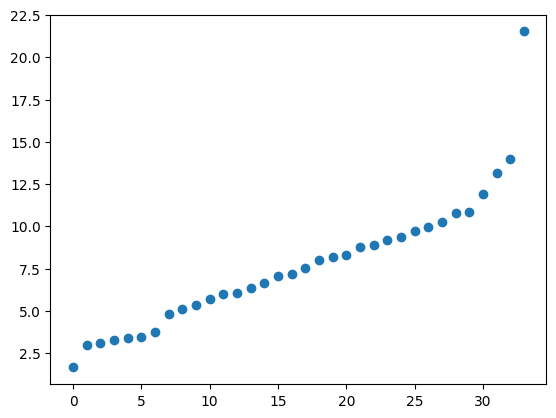

In [848]:
import matplotlib.pyplot as plt

plt.scatter([i for i in range(len(S))], np.log(S))

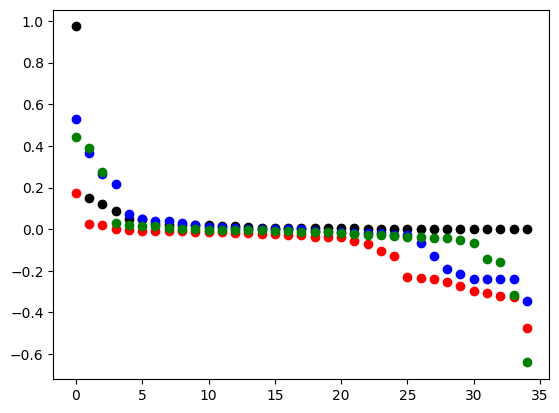

In [849]:
x = [i for i in range(35)]
plt.cla()
plt.scatter(x, sorted_feature_weights, color='black')
plt.scatter(x, sorted(Vt[cols-2], reverse=True), color='red')
plt.scatter(x, sorted(Vt[cols-3], reverse=True), color='blue')
plt.scatter(x, sorted(Vt[cols-4], reverse=True), color='green')

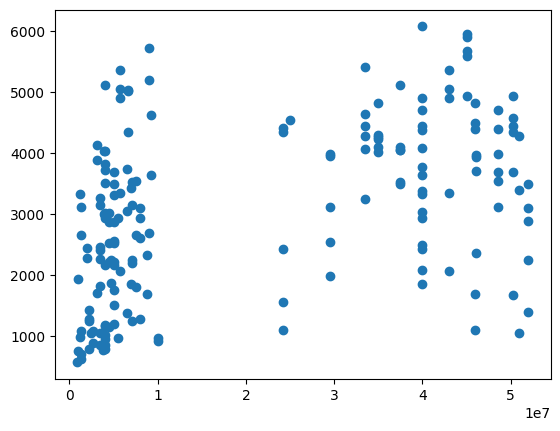

In [850]:
plt.cla()
plt.scatter(passing_df["AAV"], passing_df['yards'])